## Import libraries for data loading, modeling, and visualization
We bring in PyTorch for building neural networks, torchvision for the MNIST dataset and image transforms, and matplotlib so we can visualize digits later on.

In [1]:
import time
from pathlib import Path

import torch
from torchvision import datasets
from torchvision.transforms import ToTensor

from torch.utils.data import DataLoader

import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import matplotlib.pyplot as plt

## Download the MNIST datasets and convert them to tensors
MNIST is a collection of 28x28 grayscale images of handwritten digits (0–9). We download both the training and test splits and immediately convert each image into a PyTorch tensor so the model can work with them.

In [2]:
train_data = datasets.MNIST(
    root="data", train=True, transform=ToTensor(), download=True
)

test_data = datasets.MNIST(
    root="data", train=False, transform=ToTensor(), download=True
)

## Double-check the tensor shape of the training set
Inspecting the shape confirms how many training samples we have and ensures each image is 28x28 pixels with a single channel.

In [3]:
train_data.data.shape

torch.Size([60000, 28, 28])

## Verify the tensor shape of the test set
The test set should mirror the same structure so evaluation uses data identical to the training format.

In [4]:
test_data.data.shape

torch.Size([10000, 28, 28])

## Inspect the label tensor to confirm class coverage
Viewing the labels helps verify that all digits are present and that labels align with the image tensors.

In [5]:
train_data.targets

tensor([5, 0, 4,  ..., 5, 6, 8])

## Build PyTorch data loaders for training and evaluation
DataLoaders handle shuffling, batching, and parallel loading, which keeps the training loop clean and efficient.

In [6]:
loaders = {
    "train": DataLoader(train_data, batch_size=100, shuffle=True, num_workers=1),
    "test": DataLoader(test_data, batch_size=100, shuffle=True, num_workers=1),
}

## Define the convolutional neural network used for MNIST classification
This class builds a small CNN: two convolutional layers capture image patterns, followed by fully connected layers that map the extracted features to digit predictions.

In [7]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()

        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, 10)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = x.view(-1, 320)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)

        return x

## Configure device, instantiate the model, and define optimizer, loss, and loops
We move everything to GPU if available, create the CNN, choose the Adam optimizer to adjust weights, and set cross-entropy as the loss to measure prediction quality against labels. The `train` helper runs one pass through the shuffled training batches, while `test` switches the model to evaluation mode and measures accuracy on unseen data without updating weights.

In [8]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = CNN().to(device)

optimizer = optim.Adam(model.parameters(), lr=0.001)

loss_fn = nn.CrossEntropyLoss()

MODEL_STATE_PATH = Path("mnist_cnn.pt")


def train(epoch):
    model.train()
    for batch_idx, (data, target) in enumerate(loaders["train"]):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = loss_fn(output, target)
        loss.backward()
        optimizer.step()
        if batch_idx % 20 == 0:
            print(
                f"Train Epoch: {epoch} [{batch_idx * len(data)}/{len(loaders['train'].dataset)} ({100.0 * batch_idx / len(loaders['train']):.0f}%)]\t{loss.item():.6}"
            )


def test():
    model.eval()

    test_loss = 0
    correct = 0

    with torch.no_grad():
        for data, target in loaders["test"]:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += loss_fn(output, target).item()
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(loaders["test"].dataset)
    print(
        f"\nTest set: Average loss: {test_loss:.4f}, Accuracy {correct}/{len(loaders['test'].dataset)} ({100.0 * correct / len(loaders['test'].dataset):.0f}%\n)"
    )

## Load existing weights or train for multiple epochs
If a saved checkpoint exists we ask whether to reuse it; otherwise we loop through the dataset ten times, logging accuracy after each epoch before persisting the weights.

In [9]:
def run_training_flow():
    retrain = True
    if MODEL_STATE_PATH.exists():
        choice = (
            input(
                f"Existing weights found at {MODEL_STATE_PATH}. "
                "Press Enter to use them, or type 'r' to retrain: "
            )
            .strip()
            .lower()
        )
        retrain = choice == "r"

    if retrain:
        print(f"Model is currently being trained using {str(device).upper()}")
        time.sleep(1)
        for epoch in range(1, 11):
            train(epoch)
            test()
        torch.save(model.state_dict(), MODEL_STATE_PATH)
        print(f"Saved trained weights to {MODEL_STATE_PATH}")
    else:
        model.load_state_dict(torch.load(MODEL_STATE_PATH, map_location=device))
        model.to(device)
        print(f"Loaded trained weights from {MODEL_STATE_PATH}")


if __name__ == "__main__":
    run_training_flow()

Existing weights found at mnist_cnn.pt. Press Enter to use them, or type 'r' to retrain:  


Loaded trained weights from mnist_cnn.pt


## Run a sample inference and visualize the corresponding digit
After training, we grab a user-selected test image (defaults to index 0 when no input is provided), run it through the model to get a prediction, and display the digit so we can visually verify the result makes sense.

Enter test sample index (0-9999, default 0):  50


Prediction for sample 50: 6


Display the digit with matplotlib? [y/N]:  y


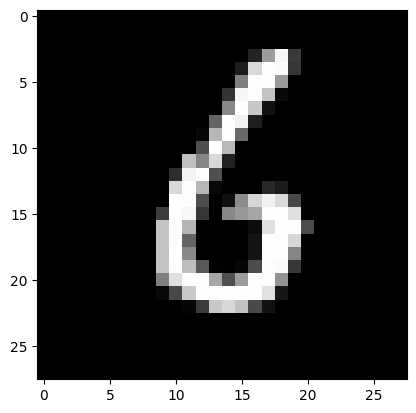

Classify another test sample? [y/N]:  y
Enter test sample index (0-9999, default 0):  70


Prediction for sample 70: 7


Display the digit with matplotlib? [y/N]:  y


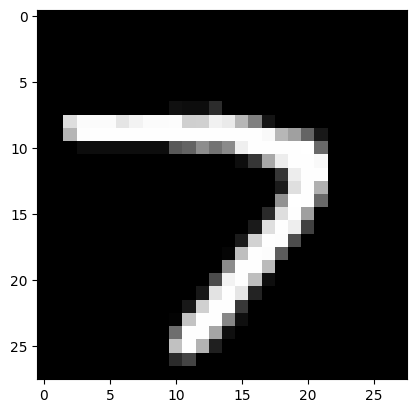

Classify another test sample? [y/N]:  


In [10]:
def run_sample_inference():
    model.eval()

    default_sample_index = 0

    max_index = len(test_data) - 1

    while True:
        user_choice = input(
            f"Enter test sample index (0-{max_index}, default {default_sample_index}): "
        ).strip()

        if user_choice:
            try:
                sample_index = int(user_choice)
            except ValueError:
                print("Invalid input, defaulting to index 0.")
                sample_index = default_sample_index
        else:
            sample_index = default_sample_index

        sample_index = max(0, min(sample_index, max_index))

        data, target = test_data[sample_index]

        data = data.unsqueeze(0).to(device)

        output = model(data)

        prediction = output.argmax(dim=1, keepdim=True).item()

        print(f"Prediction for sample {sample_index}: {prediction}")

        show_choice = input("Display the digit with matplotlib? [y/N]: ").strip().lower()
        if show_choice in ("y", "yes"):
            image = data.squeeze(0).squeeze(0).cpu().numpy()
            plt.imshow(image, cmap="gray")
            plt.show()

        repeat_choice = input("Classify another test sample? [y/N]: ").strip().lower()
        if repeat_choice not in ("y", "yes"):
            break


if __name__ == "__main__":
    run_sample_inference()